In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
    
from utils.classification import load_model, load_features, load_data, weighted_smoothing, load_behaviors
from utils.meta import *
from tqdm import notebook
import pickle
import os
import pandas as pd

### load model, preprocessed pose (filter out low likelihood), and binned features (smoothed distances, speed, angle etc)

In [8]:
model_path = '../model/model.pkl'
model = load_model(model_path)
data_path = '../processed_dataset/raw_data.pkl'
poses = load_data(data_path)
features_path = '../processed_dataset/binned_features.pkl'
features = load_features(features_path)

In [9]:
features['Female']['Group1']['Condition1']['file0'][0]

array([[  4.63054492,  40.86973781,  26.61928811, ...,   6.70898446,
         36.38520622,  35.22702859],
       [  3.36373213,  35.20939932,  26.78679427, ...,  56.4942333 ,
         25.86776393,  24.8294438 ],
       [ 40.1075854 ,  34.7793556 ,  37.61409457, ...,  13.39131696,
         17.98808656,  26.2004224 ],
       ...,
       [ 32.43888699, 138.7055428 , 138.05428916, ...,  51.36845624,
         55.71473436,  54.21091793],
       [176.26178044,  93.13948199,  68.63581288, ...,  83.5004515 ,
         38.16824506,  36.2898129 ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

### predict behaviors based on features

In [10]:
repeat_n = 6
if 'behaviors.pkl' not in os.listdir('../processed_dataset/'):

    behaviors = {key: [] for key in sexes}
    for sex in notebook.tqdm(sexes):
        behaviors[sex] = {key: [] for key in groups}
        for group in notebook.tqdm(groups):
            if group == 'Group6':
                behaviors[sex][group] = {key: [] for key in [conditions_extra[0]]}
                for condition in [conditions_extra[0]]:
    
                    behaviors[sex][group][condition] = {key: [] for key in [f'file{i}' 
                                                       for i in range(len(poses[sex][group][condition]))]}
    
                    for i in range(len(poses[sex][group][condition])):
                        total_n_frames = poses[sex][group][condition][f'file{i}'].shape[0]
                        # predict downsampled features
                        predict_ds = model.predict(features[sex][group][condition][f'file{i}'][0])
                        # upsample by duplicating
                        predictions = np.pad(predict_ds.repeat(repeat_n), (repeat_n, 0), 'edge')[:total_n_frames]
                        # smooth with minimum 12 frames (200ms)
                        behaviors[sex][group][condition][f'file{i}'] = weighted_smoothing(predictions, size=12)
    
            elif group == 'Group7':
                behaviors[sex][group] = {key: [] for key in [conditions_extra[1]]}
                for condition in [conditions_extra[1]]:
                    behaviors[sex][group][condition] = {key: [] for key in [f'file{i}' 
                                   for i in range(len(poses[sex][group][condition]))]}

                    for i in range(len(poses[sex][group][condition])):
                        total_n_frames = poses[sex][group][condition][f'file{i}'].shape[0]
                        # predict downsampled features
                        predict_ds = model.predict(features[sex][group][condition][f'file{i}'][0])
                        # upsample by duplicating
                        predictions = np.pad(predict_ds.repeat(repeat_n), (repeat_n, 0), 'edge')[:total_n_frames]
                        # smooth with minimum 12 frames (200ms)
                        behaviors[sex][group][condition][f'file{i}'] = weighted_smoothing(predictions, size=12)
            else:
                behaviors[sex][group] = {key: [] for key in conditions}
                for condition in notebook.tqdm(conditions):
                    behaviors[sex][group][condition] = {key: [] for key in [f'file{i}' 
                                                       for i in range(len(poses[sex][group][condition]))]}
    
                    for i in range(len(poses[sex][group][condition])):
                        total_n_frames = poses[sex][group][condition][f'file{i}'].shape[0]
                        # predict downsampled features
                        predict_ds = model.predict(features[sex][group][condition][f'file{i}'][0])
                        # upsample by duplicating
                        predictions = np.pad(predict_ds.repeat(repeat_n), (repeat_n, 0), 'edge')[:total_n_frames]
                        # smooth with minimum 12 frames (200ms)
                        behaviors[sex][group][condition][f'file{i}'] = weighted_smoothing(predictions, size=12)
else:
    behaviors = load_behaviors('../processed_dataset/behaviors.pkl')

In [11]:
if 'behaviors.pkl' not in os.listdir('../processed_dataset/'):
    with open('../processed_dataset/behaviors.pkl', 'wb') as f:
        pickle.dump(behaviors, f)
else:
    print('Predicted behaviors exists!')

Predicted behaviors exists!


In [12]:
behaviors['Male']['Group1']['Condition3']['file5'][:3600] # 3600frames = 1 minute (60*60)

array([0, 0, 0, ..., 2, 2, 2])

In [33]:
np.hstack([behaviors['Male']['Group1']['Condition1'][f'file{i}'] for i in range(len(behaviors['Male']['Group1']['Condition1']))])

array([2, 2, 2, ..., 1, 1, 1])

### quick view of example behavior distribution

In [59]:
selected_sex = 'Male'
selected_group = 'Group3'
selected_condition = 'Condition3'

predict_dict = {'condition': np.repeat(selected_condition, 
                                       len(np.hstack([behaviors[selected_sex][selected_group][selected_condition][f'file{i}'] 
                                                      for i in range(len(behaviors[selected_sex][selected_group][selected_condition]))]))),
                'behavior': np.hstack([behaviors[selected_sex][selected_group][selected_condition][f'file{i}'] 
                                       for i in range(len(behaviors[selected_sex][selected_group][selected_condition]))])}
df_raw = pd.DataFrame(data=predict_dict)
labels = df_raw['behavior'].value_counts(sort=False).index
values = df_raw['behavior'].value_counts(sort=False).values
# summary dataframe
df = pd.DataFrame()
behavior_labels = []
for l in labels:
    behavior_labels.append(behavior_names[int(l)])
df["values"] = values
df['labels'] = behavior_labels
df["colors"] = df["labels"].apply(lambda x:
                                  behavior_colors[behavior_names.index(x)])  # to connect Column value to Color in Dict
df

,values,labels,colors
0,428950,walking,darkcyan
1,154464,grooming,royalblue
2,39348,licking hindpaw L,rebeccapurple
3,378743,still,crimson
4,115957,rearing,goldenrod
5,7536,licking hindpaw_R,mediumorchid


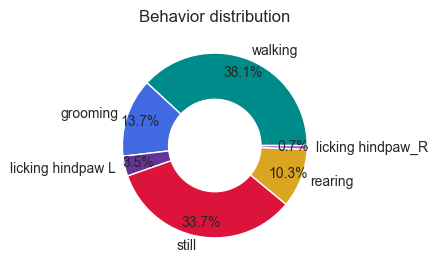

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# Pie Chart
ax.pie(df['values'], 
       colors=df['colors'], 
       labels=df['labels'],
       autopct='%1.1f%%', pctdistance=0.85)
# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
ax.set_title('Behavior distribution')
# Displaying Chart
plt.show()

### file save, change the extension to change the file format

In [65]:
fig.savefig(f'../figures/example_distribution_'
            f'{selected_sex}_{selected_group}_{selected_condition}.svg', 
            dpi=600, bbox_inches='tight')